In [1]:
import pandas as pd
import numpy as np
import random
import json
import pickle
from os import path, makedirs

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

In [3]:
# Set random seed
random.seed(1337)

In [4]:
def pretty_print(data_dict):
    try:
        print(json.dumps(data_dict, indent=4))
    except TypeError:
        print(data_dict)
    except Exception as e:
        print(str(e))

In [5]:
def load_data(data_path='../data/', is_clean=0, is_os=0):
    clean = '_clean' if is_clean else ''
    os = '_os' if is_os else ''
    data_sets = {}
    data_cols = [
        'data', 'X_train', 'X_val', 'X_train_val', 'X_test', \
        'y_train', 'y_val', 'y_train_val', 'y_test'
    ]
    
    for i, col in enumerate(data_cols):
        data_cols[i] = col + clean + os
    
    for col in data_cols:
        data_sets[col] = pickle.load(open(data_path+'{}.pkl'.format(col),'rb'))
    
    return data_sets

In [6]:
is_clean, is_os = 1, 0
clean, os = '_clean', ''
pickle_path = '../pickle_objects/'
model_path = pickle_path + 'models/'

In [7]:
data_sets = load_data('../data/', is_clean=1, is_os=0)

In [8]:
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [9]:
data_sets['data'+clean+os].head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edit username hardcore metallica f...,0,0,0,0,0,0
1,000103f0d9cfb60f,d'aww match background colour -pron- seemingly...,0,0,0,0,0,0
2,000113f07ec002fd,hey man -pron- not try edit war -pron- guy con...,0,0,0,0,0,0
3,0001b41b1c6bb37e,not real suggestion improvement wonder section...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0
5,00025465d4725e87,congratulations good use tool good · talk,0,0,0,0,0,0
6,0002bcb3da6cb337,cocksucker piss work,1,1,1,0,1,0
7,00031b1e95af7921,vandalism matt shirvington article revert not ban,0,0,0,0,0,0
8,00037261f536c51d,sorry word nonsense offensive -pron- not inten...,0,0,0,0,0,0
9,00040093b2687caa,alignment subject contrary dulithgow,0,0,0,0,0,0


In [10]:
data_sets['X_train'+clean+os].head()

,id,comment_text
101689,202d64bd4c2bd9a4,champion hurdle delighted use 1 2_3 image uplo...
26429,4601831cd03ec679,edit war currently appear engage edit war note...
62499,a73c6f5b69d963be,-pron- wrong bud ready use taran boi verdict n...
10145,1ad558921b36c611,attempt change las vegas season las vegas augu...
16254,2adc0c27c1165eef,people arab homosexual bad thing d**n f***in h...


In [11]:
# Print value counts for each target
for target in target_cols:
    print('{}:'.format(target))
    for data in data_sets:
        if 'y' in data:
            value_counts = data_sets[data][target].value_counts()
            print('{}: {:.3f}%\t'.format(data, 100*value_counts[1]/sum(value_counts)), end='')
    print('\n')

toxic:
y_train_clean: 9.528%	y_val_clean: 9.551%	y_train_val_clean: 9.533%	y_test_clean: 9.789%	

severe_toxic:
y_train_clean: 1.005%	y_val_clean: 0.993%	y_train_val_clean: 1.002%	y_test_clean: 0.990%	

obscene:
y_train_clean: 5.321%	y_val_clean: 5.274%	y_train_val_clean: 5.309%	y_test_clean: 5.239%	

threat:
y_train_clean: 0.287%	y_val_clean: 0.295%	y_train_val_clean: 0.289%	y_test_clean: 0.342%	

insult:
y_train_clean: 4.960%	y_val_clean: 4.860%	y_train_val_clean: 4.935%	y_test_clean: 4.941%	

identity_hate:
y_train_clean: 0.902%	y_val_clean: 0.833%	y_train_val_clean: 0.885%	y_test_clean: 0.862%	



In [12]:
num_feats = 1000
n_grams = 2
ngram_range = list(map(lambda x: x+1,range(n_grams)))

In [13]:
def load_ngrams(data, num_feats, ngram_range, pickle_path='../pickle_objects/', is_clean=1, is_os=0):
    clean = '_clean' if is_clean else ''
    os = '_os' if is_os else ''
    ngrams = {}
    vec_params = {'analyzer': 'word', 'lowercase': True,'max_features': num_feats, 'ngram_range': ngram_range}
    
    for vec in ['countvec', 'tfidf']:
        # Load vectorizer if present
        file_name = '{}{}_{}_ngrams_{}{}.pkl'.format(pickle_path, vec, num_feats, n_grams, clean+os)
        if path.isfile(file_name):
            ngrams[vec] = pickle.load(open(file_name, 'rb'))
        else:
            # Fit, store, and load vectorizer
            ngrams_vec = CountVectorizer(**vec_params) if vec == 'countvec' else TfidfVectorizer(**vec_params)
            ngrams_vec.fit(data['comment_text'])
            ngrams[vec] = ngrams_vec
            if not path.exists(pickle_path):
                makedirs(pickle_path)
            pickle.dump(ngrams_vec, open(file_name, 'wb'))
    return ngrams

In [14]:
ngrams = load_ngrams(data_sets['X_train'+clean+os], num_feats, ngram_range, \
                     pickle_path, is_clean, is_os)

In [15]:
def transform_to_ngrams(data_set, data_cols, ngrams):
    for data in data_cols:
        for vec in ['countvec', 'tfidf']:
            data_sets[data+'_'+vec] = ngrams[vec].transform(data_sets[data]['comment_text'])
    return data_sets

In [16]:
data_sets = transform_to_ngrams(data_sets, ['X_train'+clean+os, 'X_val'+clean+os, \
                                            'X_train_val'+clean+os, 'X_test'+clean+os], ngrams)

In [17]:
def normalize_data(X_train, X_test):
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [18]:
def fit_model(base_model, X, y, param_grid, target_cols, scoring='roc_auc', cv=None):
    if cv:
        models, mean_val_scores, params = {}, [], []
        for target in target_cols:
            model_target = GridSearchCV(base_model, param_grid, cv=cv, scoring=scoring, refit=False)
            model_target.fit(X, y[target])
            mean_val_scores.append(model_target.cv_results_['mean_test_score'])
            if not params:
                params = model_target.cv_results_['params']
        mean_val_scores = np.mean(np.array(mean_val_scores), axis=0)
        best_param_idx = np.argmax(mean_val_scores)
        models['best_params_'], models['best_mean_score_'] = \
        params[best_param_idx], mean_val_scores[best_param_idx]
    else:
        models = {}
        for target in target_cols:
            base_model.set_params(**param_grid).fit(X, y[target])
            models[target] = base_model
    return models

In [19]:
def dump_models(model, X, model_name, target_cols, model_path='../pickle_objects/models/', cv=None):
    if not path.exists(model_path):
        makedirs(model_path)
    file_name = '{}{}_{}.pkl'.format(model_path, model_name, X)
    if not path.isfile(file_name):
        pickle.dump(model, open(file_name, 'wb'))

In [20]:
def fit_all_models(data_sets, data_cols, model_list, param_grids, \
                   target_cols, model_path='../pickle_path/models/', cv=None):
    best_models, best_params, best_scores = {}, {}, {}
    X, y = data_cols
    for model in model_list:
        best_models[model] = fit_model(model_list[model], data_sets[X], \
                                          data_sets[y], param_grids[model], \
                                          target_cols, 'roc_auc', cv)
        if cv:
            print('Model = {}'.format(model))
            pretty_print(best_models[model])
        else:
            dump_models(best_models[model], X, model, target_cols, model_path, cv)
    return best_models

In [21]:
model_list = {
    'bnb': BernoulliNB(),
#     'gnb': GaussianNB(),
    'lrl1': LogisticRegression(penalty='l1'),
    'lrl2': LogisticRegression(penalty='l2'),
    'rf': RandomForestClassifier(),
    'xgb': XGBClassifier(),
    'svm': SVC(kernel='linear')
}
    
param_grids = {
    'bnb': {},
#     'gnb': {},
    'lrl1': {'C': np.concatenate((np.reciprocal(np.arange(1, 13, 3)), \
                                  np.logspace(1, 6, num=6, endpoint=True, base=10)))},
    'lrl2': {'C': np.concatenate((np.reciprocal(np.arange(1, 13, 3)), \
                                  np.logspace(1, 6, num=6, endpoint=True, base=10)))},
    'rf': {
        'n_estimators': np.arange(50, 250, 50),
        'max_features': ['auto', 'log2'],
        'max_depth': np.arange(3, 13, 2)
    },
    'xgb': {'n_estimators': [1]},
    'svm': {'C': np.concatenate((np.arange(1, 13, 3), np.logspace(1, 6, num=6, endpoint=True, base=10)))},
}

In [22]:
# Set predefined split for CV
# 0 corresponds to val, -1 to train
val_fold = [-1]*len(data_sets['X_train'+clean+os]) + [0]*len(data_sets['X_val'+clean+os])
predefined_split = PredefinedSplit(test_fold=val_fold)

In [23]:
model_list = {
    'lrl1': LogisticRegression(penalty='l1'),
#     'lrl2': LogisticRegression(penalty='l2'),
    'rf': RandomForestClassifier()
}
    
param_grids = {
    'lrl1': {'C': [1e-1, 1e-2, 1e-3]},
#     'lrl2': {'C': [1e-1, 1e-2, 1e-3]},
    'rf': {
        'n_estimators': np.arange(1, 3, 1),
        'max_depth': np.arange(3, 5, 1)
    }
}

# Find best hyperparameter settings for each data set for each model
vec = 'countvec'
data_cols = ('X_train_val'+clean+os+'_'+vec, 'y_train_val'+clean+os)
best_models = fit_all_models(data_sets, data_cols, model_list, param_grids, \
                             target_cols, model_path, cv=predefined_split)

Model = lrl1
{
    "best_params_": {
        "C": 0.1
    },
    "best_mean_score_": 0.8893139327074749
}
Model = rf
{'best_params_': {'max_depth': 4, 'n_estimators': 2}, 'best_mean_score_': 0.6469175193046937}


In [24]:
pretty_print(best_models)

{'lrl1': {'best_params_': {'C': 0.1}, 'best_mean_score_': 0.8893139327074749}, 'rf': {'best_params_': {'max_depth': 4, 'n_estimators': 2}, 'best_mean_score_': 0.6469175193046937}}


In [25]:
def refit_best_model(data_sets, model_list, data_cols, best_models, \
                     target_cols, pickle_path='../pickle_path/'):
    # Refit all models with all data sets with best hyperparameters
    best_params = {}
    X, y = data_cols
    for model in model_list:
        best_params[model] = best_models[model]['best_params_']
    best_refitted_models = fit_all_models(data_sets, data_cols, model_list, \
                                          best_params, target_cols, model_path, cv=None)
    return best_refitted_models

In [26]:
best_refitted_models = refit_best_model(data_sets, model_list, data_cols, \
                                        best_models, target_cols, model_path)

In [27]:
def predict_labels_and_probas(fitted_models, model_list, X, target_cols):
    probabilities = {}
    for model in model_list:
        probabilities[model] = {}
        for target in target_cols:
            probabilities[model][target] = fitted_models[model][target].predict_proba(X)[:,1]
#         probabilities[model] = np.squeeze(np.asarray(probabilities[model].todense()))
    return probabilities

In [28]:
probabilities = predict_labels_and_probas(best_refitted_models, model_list, \
                                          data_sets['X_test'+clean+os+'_'+vec], target_cols)

In [29]:
def plot_model_roc_curves(y_test, probabilities, model_list, target_cols, vec='countvec', \
                          model_or_target='model', plots_path='../plots/'):
    aucs = {}
    # Plot by model
    if model_or_target == 'model':
        for model in model_list:
            aucs[model] = {}
            plt.figure(figsize=(10,8))
            for target in target_cols:
                fpr, tpr, threshold = roc_curve(y_test[target], probabilities[model][target])
                auc_value = auc(fpr, tpr)
                aucs[model][target] = auc_value
                plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+target, auc_value))
            plt.xlabel('fpr')
            plt.ylabel('tpr')
            plt.title('ROC Curve for {} with {}'.format(model, vec))
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
            plt.savefig(plots_path+'roc_'+model+'_'+vec+'.jpg')
            plt.show()
    # Plot by target column
    elif model_or_target == 'target':
        for target in target_cols:
            aucs[target] = {}
            plt.figure(figsize=(10,8))
            for model in model_list:
                fpr, tpr, threshold = roc_curve(y_test[target], probabilities[model][target])
                auc_value = auc(fpr, tpr)
                aucs[target][model] = auc_value
                plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+model, auc_value))
            plt.xlabel('fpr')
            plt.ylabel('tpr')
            plt.title('ROC Curve for {} with {}'.format(target, vec))
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
            plt.savefig(plots_path+'roc_'+target+'_'+vec+'.jpg')
            plt.show()
    else:
        raise TypeError("Parameter 'model_or_target' must be one of 'model' or 'target'.")
    return aucs

In [30]:
def get_mean_auc(aucs, model_list=None, target_cols=None, model_or_target='model'):
    mean_aucs = {}
    # Compute mean auc by model
    columns = model_list if model_or_target == 'model' else target_cols
    for col in columns:
        mean_aucs[col] = np.mean(list(aucs[col].values()))
    return mean_aucs

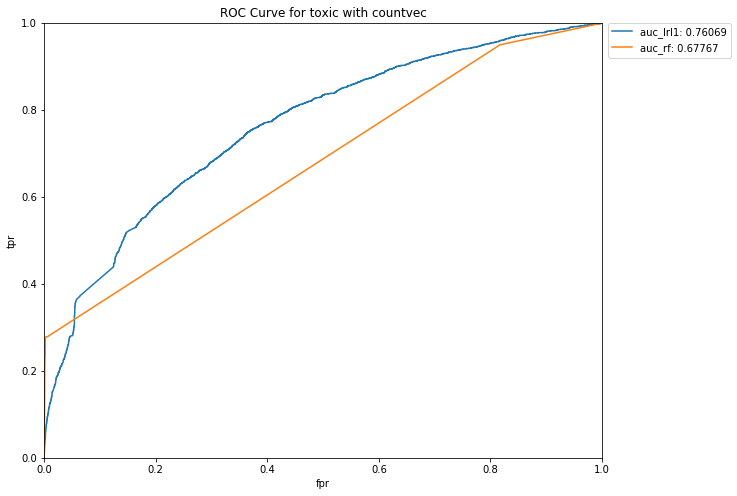

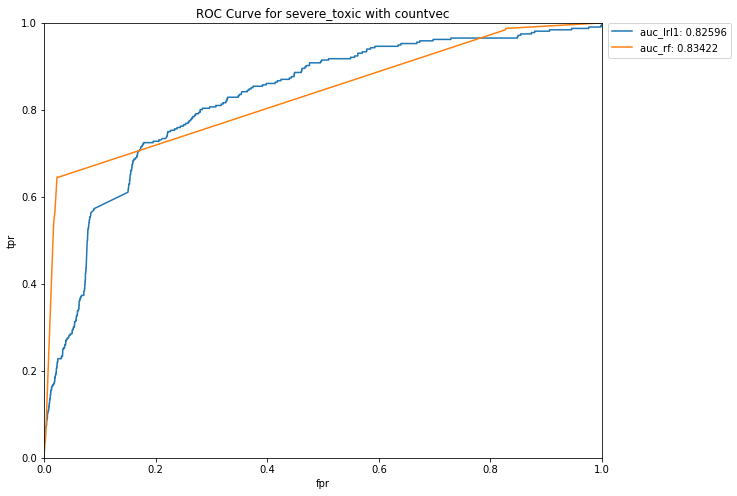

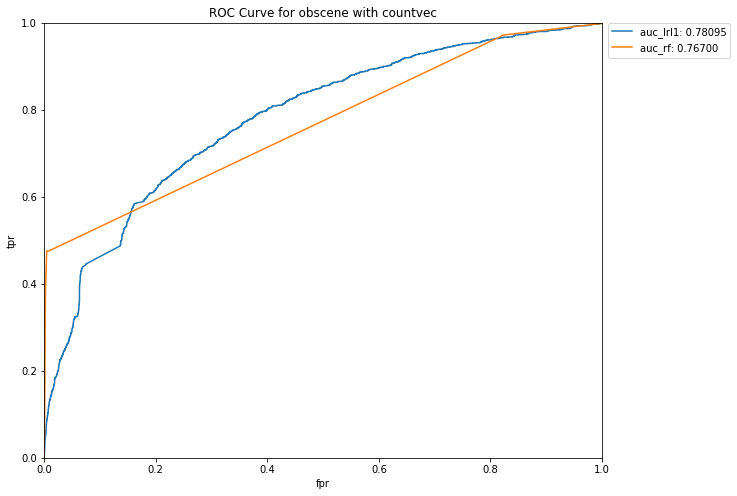

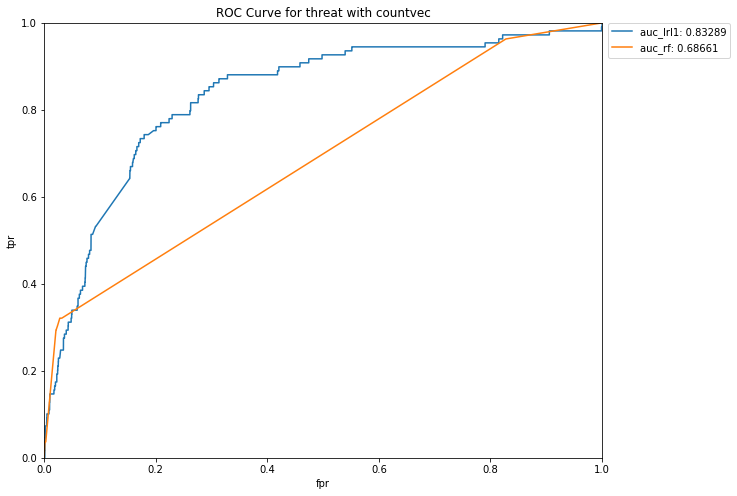

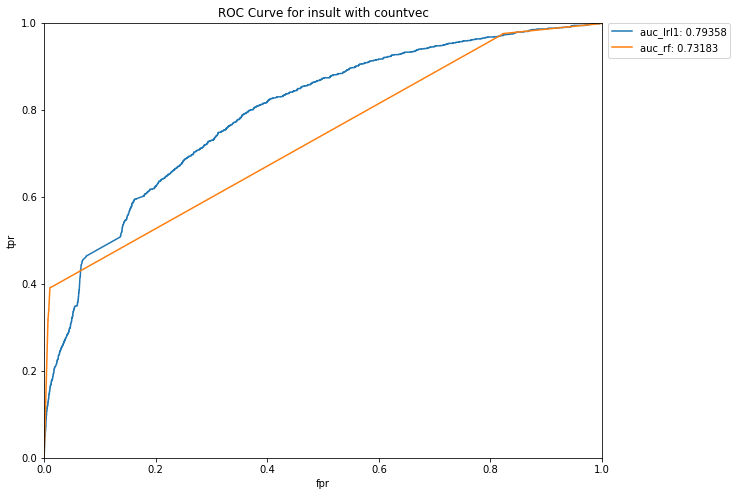

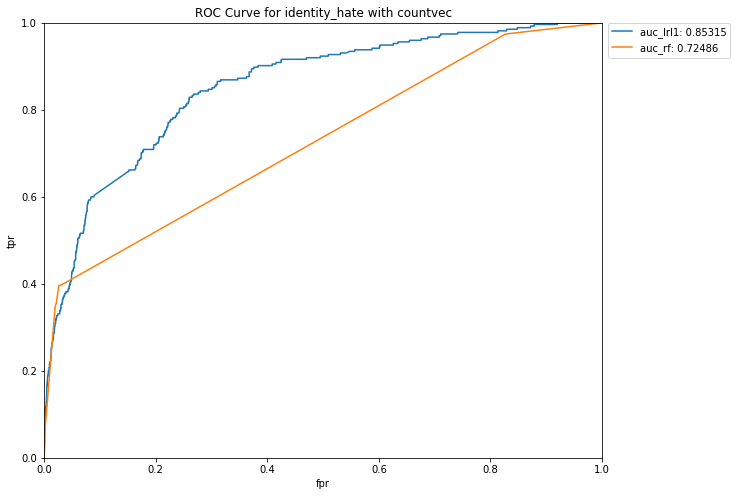

In [31]:
model_or_target = 'target'
aucs = plot_model_roc_curves(data_sets['y_test'+clean+os], probabilities, \
                      model_list, target_cols, vec, model_or_target, '../plots/')

In [32]:
pretty_print(aucs)

{
    "toxic": {
        "lrl1": 0.760691333421478,
        "rf": 0.6776656668788453
    },
    "severe_toxic": {
        "lrl1": 0.8259584804999036,
        "rf": 0.8342188364397048
    },
    "obscene": {
        "lrl1": 0.7809521385548983,
        "rf": 0.7670005629836917
    },
    "threat": {
        "lrl1": 0.8328912899129874,
        "rf": 0.6866096755156115
    },
    "insult": {
        "lrl1": 0.7935783158866248,
        "rf": 0.7318310091840764
    },
    "identity_hate": {
        "lrl1": 0.853146017699115,
        "rf": 0.7248607631306746
    }
}


In [33]:
mean_aucs = get_mean_auc(aucs, model_list, target_cols, model_or_target)

In [34]:
pretty_print(mean_aucs)

{
    "toxic": 0.7191785001501616,
    "severe_toxic": 0.8300886584698042,
    "obscene": 0.7739763507692949,
    "threat": 0.7597504827142995,
    "insult": 0.7627046625353506,
    "identity_hate": 0.7890033904148948
}


In [35]:
def get_aucs_df(aucs, model_list, target_cols, model_or_target='model'):
    aucs_df = pd.DataFrame.from_dict(aucs)
    aucs_df['mean'] = np.mean(aucs_df, axis=1)
    aucs_df.loc['mean'] = np.mean(aucs_df, axis=0)
    return aucs_df

In [36]:
aucs_df = get_aucs_df(aucs, model_list, target_cols, model_or_target)

In [39]:
pickle.dump(aucs_df, open('{}aucs_df.pkl'.format(pickle_path), 'wb'))

In [37]:
aucs_df

,identity_hate,insult,obscene,severe_toxic,threat,toxic,mean
lrl1,0.853146,0.793578,0.780952,0.825958,0.832891,0.760691,0.807870
rf,0.724861,0.731831,0.767001,0.834219,0.686610,0.677666,0.737031
mean,0.789003,0.762705,0.773976,0.830089,0.759750,0.719179,0.772450
